# Chess Piece Detection with YOLOv8

This notebook trains a YOLOv8 model to detect chess pieces on a chessboard using the ChessReD2K dataset.

## Overview
- **Input**: Chess board images
- **Output**: JSON with piece positions in algebraic notation
- **Model**: YOLOv8 for object detection
- **Dataset**: ChessReD2K (2078 images, 43149 annotations)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Setup and Installation


In [ ]:
# Install required packages
!pip install ultralytics roboflow supervision

# Import libraries
import os
import shutil
import yaml
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from IPython.display import Image, display
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yo

## 2. Load Dataset from Google Drive

**Instructions:**
1. Upload your `yolo_dataset` folder to Google Drive
2. Mount Google Drive and specify the path below


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify the path to your dataset in Google Drive
# Update this path to match where you uploaded the yolo_dataset folder
DATASET_PATH = '/content/drive/MyDrive/yolo_dataset'  # Update this path!

# Verify dataset exists
if os.path.exists(DATASET_PATH):
    print(f"Dataset found at: {DATASET_PATH}")

    # Check dataset structure
    for split in ['train', 'val', 'test']:
        images_path = os.path.join(DATASET_PATH, split, 'images')
        labels_path = os.path.join(DATASET_PATH, split, 'labels')

        if os.path.exists(images_path) and os.path.exists(labels_path):
            img_count = len(os.listdir(images_path))
            label_count = len(os.listdir(labels_path))
            print(f"{split}: {img_count} images, {label_count} labels")
        else:
            print(f"Warning: {split} folder not found or incomplete")
else:
    print(f"Dataset not found at: {DATASET_PATH}")
    print("Please upload your yolo_dataset folder to Google Drive and update the DATASET_PATH variable.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset found at: /content/drive/MyDrive/yolo_dataset
train: 1454 images, 1454 labels
val: 312 images, 312 labels
test: 312 images, 312 labels


In [ ]:
# Load dataset configuration
config_path = os.path.join(DATASET_PATH, 'dataset.yaml')

if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        dataset_config = yaml.safe_load(f)

    print("Dataset Configuration:")
    print(f"Number of classes: {dataset_config['nc']}")
    print(f"Class names: {dataset_config['names']}")

    # Update paths to absolute paths in Colab
    dataset_config['path'] = DATASET_PATH
    dataset_config['train'] = os.path.join(DATASET_PATH, 'train/images')
    dataset_config['val'] = os.path.join(DATASET_PATH, 'val/images')
    dataset_config['test'] = os.path.join(DATASET_PATH, 'test/images')

    # Save updated config
    colab_config_path = '/content/dataset.yaml'
    with open(colab_config_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)

    print(f"Updated config saved to: {colab_config_path}")
else:
    print(f"Configuration file not found: {config_path}")


Dataset Configuration:
Number of classes: 13
Class names: ['white-pawn', 'white-rook', 'white-knight', 'white-bishop', 'white-queen', 'white-king', 'black-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-queen', 'black-king', 'empty']
Updated config saved to: /content/dataset.yaml


## 3. Train YOLOv8 Model


In [ ]:
# Initialize YOLOv8 model
# You can use different model sizes: yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
# Using yolov8m for A100 GPU - good balance of speed and accuracy
model = YOLO('yolov8m.pt')  # Medium model for A100 GPU

# Training parameters optimized for A100 GPU
EPOCHS = 100  # More epochs for better convergence
IMG_SIZE = 832  # Larger image size for better detail recognition
BATCH_SIZE = 32  # Larger batch size to utilize A100 memory (80GB)

print(f"=== DUAL MODEL TRAINING ===")
print(f"Piece Model - Epochs: {EPOCHS}, Image size: {IMG_SIZE}, Batch size: {BATCH_SIZE}")

# Train Piece Detection Model
print("\\n🎯 Training Piece Detection Model...")
piece_results = model.train(
    data=colab_config_path,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name='chess_pieces',
    save=True,
    verbose=True,
    patience=15,
    save_period=5,
    optimizer='AdamW',
    lr0=0.001,
    weight_decay=0.0005,
    augment=True,
    mixup=0.1,
    copy_paste=0.1,
)

print("\\n✅ Piece detection model is trained successfully!")


=== DUAL MODEL TRAINING ===
Piece Model - Epochs: 100, Image size: 832, Batch size: 32
\n🎯 Training Piece Detection Model...
Ultralytics 8.3.190 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=832, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chess_pieces, nbs=64,

## 4. Chess Position Detection Function
#### (Removed)

## 5. Save Model and Results


In [ ]:
# Save  model to Google Drive
piece_model_path = '/content/drive/MyDrive/chess_pieces_model.pt'

shutil.copy('/content/runs/detect/chess_pieces/weights/best.pt', piece_model_path)

print(f"Piece detection model saved: {piece_model_path}")

# Save training results for both models
!zip -r /content/chess_training_results.zip /content/runs/

drive_results_path = '/content/drive/MyDrive/chess_training_results.zip'
shutil.copy('/content/chess_training_results.zip', drive_results_path)

print(f"All training results saved: {drive_results_path}")

print("\\n🎉 DUAL MODEL TRAINING COMPLETED! 🎉")
print("\\nFiles saved to Google Drive:")
print(f"✅ Piece Detection Model: {piece_model_path}")
print(f"✅ Training Results: {drive_results_path}")
print("\\n🚀 Your system can now detect chess pieces on the chess board!")


Piece detection model saved: /content/drive/MyDrive/chess_pieces_model.pt
  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/chess_pieces/ (stored 0%)
  adding: content/runs/detect/chess_pieces/val_batch0_pred.jpg (deflated 5%)
  adding: content/runs/detect/chess_pieces/args.yaml (deflated 52%)
  adding: content/runs/detect/chess_pieces/confusion_matrix.png (deflated 18%)
  adding: content/runs/detect/chess_pieces/val_batch1_pred.jpg (deflated 5%)
  adding: content/runs/detect/chess_pieces/weights/ (stored 0%)
  adding: content/runs/detect/chess_pieces/weights/epoch20.pt (deflated 48%)
  adding: content/runs/detect/chess_pieces/weights/epoch5.pt (deflated 48%)
  adding: content/runs/detect/chess_pieces/weights/epoch35.pt (deflated 49%)
  adding: content/runs/detect/chess_pieces/weights/epoch10.pt (deflated 48%)
  adding: content/runs/detect/chess_pieces/weights/epoch25.pt (deflated 48%)
  adding: content/runs/detect/chess_pieces

## 6. Train Corner Detection Model


In [ ]:
# Train corner detection model
corner_config_path = '/content/drive/MyDrive/yolo_corner_dataset/dataset.yaml'

if os.path.exists(corner_config_path):
    print("Training corner detection model...")

    # Initialize corner detection model (smaller model for point detection)
    corner_model = YOLO('yolov8n.pt')  # Nano model is sufficient for 4 corner points

    # Training parameters for corner detection
    CORNER_EPOCHS = 50  # Fewer epochs needed for simpler task
    CORNER_IMG_SIZE = 640
    CORNER_BATCH_SIZE = 48  # Can use larger batch for simpler task

    print(f"Corner detection training: {CORNER_EPOCHS} epochs, size {CORNER_IMG_SIZE}, batch {CORNER_BATCH_SIZE}")

    # Train corner detection model
    corner_results = corner_model.train(
        data=corner_config_path,
        epochs=CORNER_EPOCHS,
        imgsz=CORNER_IMG_SIZE,
        batch=CORNER_BATCH_SIZE,
        name='corner_detection',
        save=True,
        verbose=True,
        patience=10,
        save_period=5,
        optimizer='AdamW',
        lr0=0.001,
        weight_decay=0.0005,
    )

    print("Corner detection training completed!")

    # Save corner model to Drive
    corner_model_path = '/content/drive/MyDrive/chess_corner_model.pt'
    shutil.copy('/content/runs/detect/corner_detection/weights/best.pt', corner_model_path)
    print(f"Corner model saved to: {corner_model_path}")

else:
    print("Corner dataset not found. Skipping corner model training.")
    print("Make sure to upload chessred2k_annotations.json and run the previous cell.")


Training corner detection model...
Corner detection training: 50 epochs, size 640, batch 48
Ultralytics 8.3.190 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=48, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo_corner_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=corner_detection, nb

## 7. Combined Chess Detection Function (Two Models)


Loading models...
✅ Both models loaded!
Testing with: G083_IMG092.jpg

image 1/1 /content/drive/MyDrive/yolo_dataset/test/images/G083_IMG092.jpg: 832x832 2 white-pawns, 1 white-rook, 1 white-king, 2 black-pawns, 1 black-rook, 1 black-king, 8.9ms
Speed: 5.6ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 832, 832)

image 1/1 /content/drive/MyDrive/yolo_dataset/test/images/G083_IMG092.jpg: 640x640 1 top_left, 1 top_right, 1 bottom_left, 1 bottom_right, 6.8ms
Speed: 3.5ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


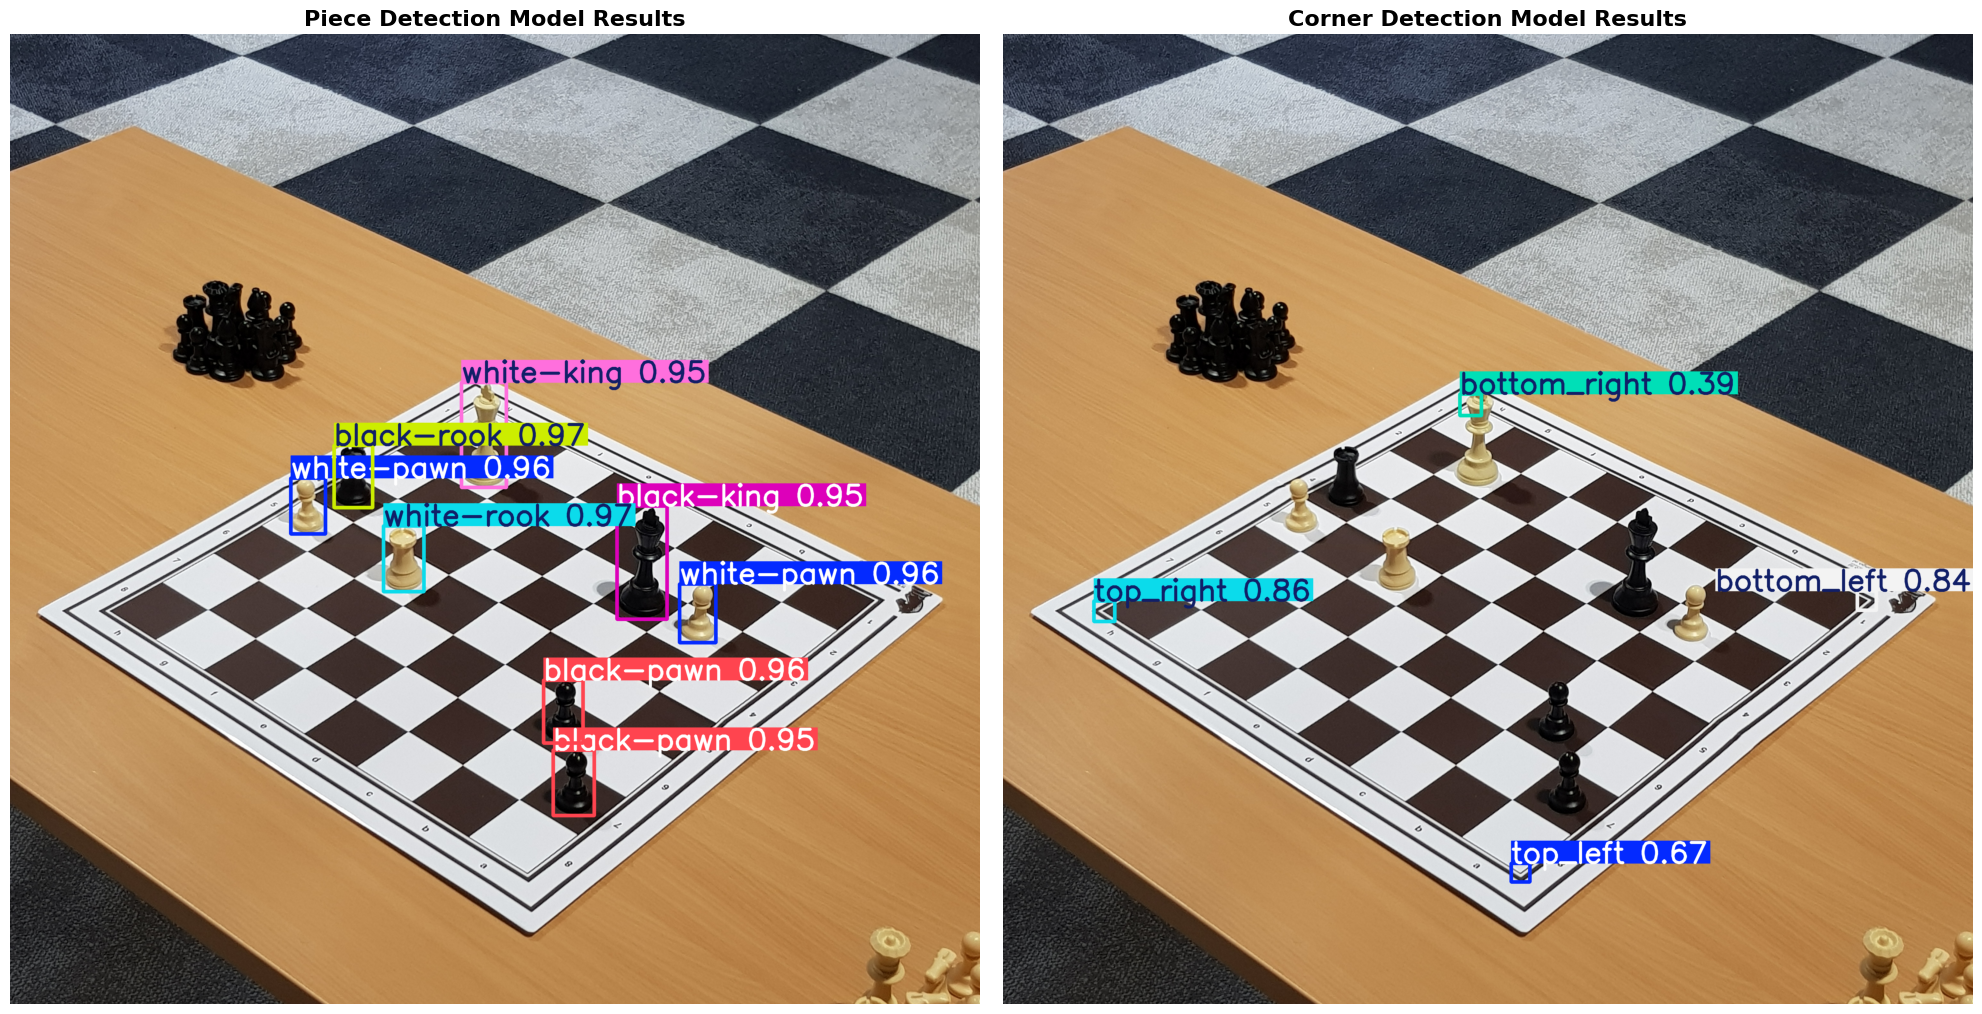

In [118]:
# Simplified code to show just the image results from both models

import matplotlib.pyplot as plt
import cv2
import os

def show_dual_model_results(piece_model, corner_model, image_path):
    """
    Display side-by-side results from piece detection and corner detection models.
    """

    # Run both models on the same image
    piece_results = piece_model(image_path)
    corner_results = corner_model(image_path) if corner_model else None

    # Create side-by-side visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Left: Piece detection results
    piece_img = piece_results[0].plot()
    axes[0].imshow(cv2.cvtColor(piece_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Piece Detection Model Results", fontsize=16, fontweight='bold')
    axes[0].axis('off')

    # Right: Corner detection results
    if corner_results:
        corner_img = corner_results[0].plot()
        axes[1].imshow(cv2.cvtColor(corner_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Corner Detection Model Results", fontsize=16, fontweight='bold')
    else:
        # Fallback if corner model not available
        axes[1].text(0.5, 0.5, 'Corner Model\nNot Available',
                    ha='center', va='center', transform=axes[1].transAxes,
                    fontsize=20, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1].set_title("Corner Detection Model Results", fontsize=16, fontweight='bold')

    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution - just the model results visualization
if __name__ == "__main__":
    # Load your trained models
    piece_model_path = '/content/runs/detect/chess_pieces/weights/best.pt'
    corner_model_path = '/content/runs/detect/corner_detection/weights/best.pt'

    if os.path.exists(piece_model_path):
        from ultralytics import YOLO

        print("Loading models...")
        piece_model = YOLO(piece_model_path)

        corner_model = None
        if os.path.exists(corner_model_path):
            corner_model = YOLO(corner_model_path)
            print("✅ Both models loaded!")
        else:
            print("⚠️ Only piece model available.")

        # Get test image
        test_images_dir = '/content/drive/MyDrive/yolo_dataset/test/images'
        test_image_files = os.listdir(test_images_dir)

        if test_image_files:
            sample_image = os.path.join(test_images_dir, test_image_files[1])
            print(f"Testing with: {test_image_files[1]}")

            # Show the dual model results
            show_dual_model_results(piece_model, corner_model, sample_image)

    else:
        print("❌ Models not found. Please train the models first.")


image 1/1 /content/drive/MyDrive/yolo_dataset/test/images/G083_IMG093.jpg: 640x640 2 top_lefts, 1 top_right, 1 bottom_left, 1 bottom_right, 7.0ms
Speed: 3.8ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Chosen 4 indices (0, 1, 2, 3), order (1, 2, 0, 3), reproj err=0.00px


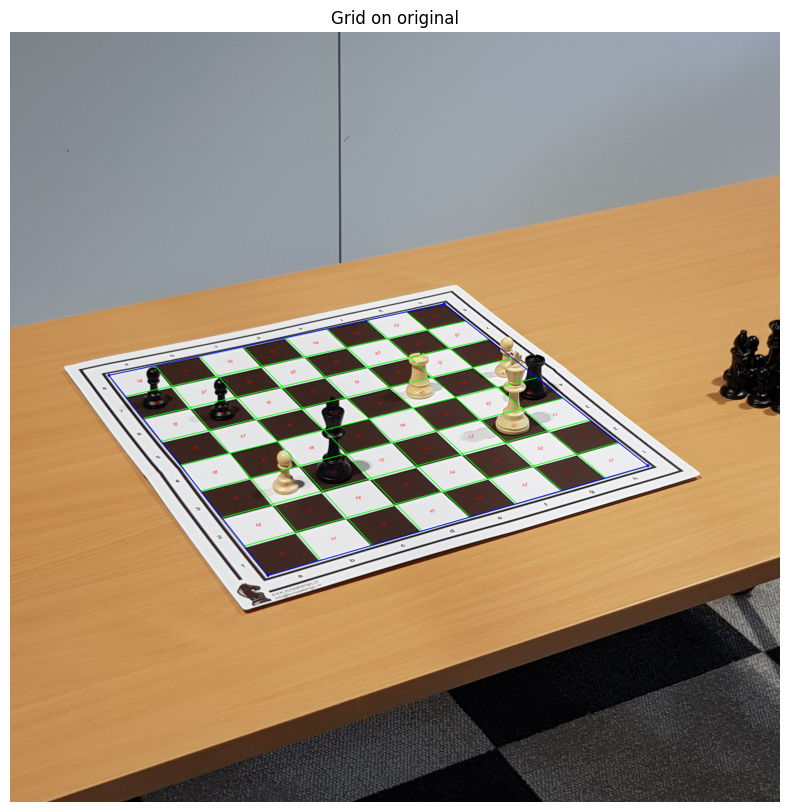

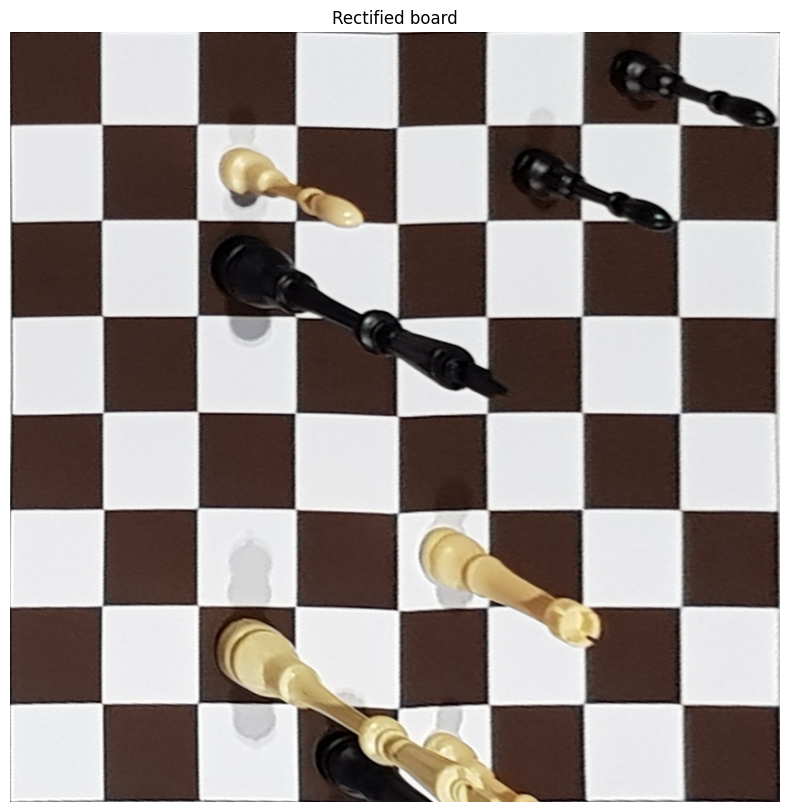

In [115]:
# === Colab cell: robust grid drawing from raw YOLO corner points ===
import cv2, numpy as np, itertools
from ultralytics import YOLO

def warp_pts(H, pts_xy):
    pts = np.asarray(pts_xy, dtype=np.float32).reshape(-1,1,2)
    return cv2.perspectiveTransform(pts, H).reshape(-1,2)

def best_H_for_4points(pts4, warp_size=800):
    pts4 = np.asarray(pts4, dtype=np.float32).reshape(4,2)
    dst = np.array([[0,0],[warp_size,0],[warp_size,warp_size],[0,warp_size]], dtype=np.float32)
    best = None
    for perm in itertools.permutations(range(4), 4):
        src = pts4[list(perm)]
        H = cv2.getPerspectiveTransform(src, dst)
        if not np.isfinite(H).all() or np.allclose(H, 0):
            continue
        proj = warp_pts(H, src)
        err = float(np.mean(np.linalg.norm(proj - dst, axis=1)))
        if best is None or err < best[0]:
            best = (err, H, perm)
    if best is None:
        raise ValueError("No valid H for given 4 points")
    return best  # (err, H, perm)

def cluster_points(points, confs, tol=150.0):
    # points: (N,2), confs: (N,)
    order = np.argsort(-confs)
    clusters = []
    for idx in order:
        p = points[idx]
        placed = False
        for g in clusters:
            if np.hypot(*(p - g['pt'])) < tol:
                placed = True
                break
        if not placed:
            clusters.append({'pt': p, 'conf': confs[idx]})
    out_pts  = np.array([c['pt'] for c in clusters], dtype=np.float32)
    out_conf = np.array([c['conf'] for c in clusters], dtype=np.float32)
    return out_pts, out_conf

def select_best_4(points, warp_size=800):
    # Try all 4-combos (up to ~10 points is fine) and pick the combo/ordering with min reprojection error
    n = len(points)
    best = None
    for combo in itertools.combinations(range(n), 4):
        pts4 = points[list(combo)]
        try:
            err, H, perm = best_H_for_4points(pts4, warp_size)
            if best is None or err < best[0]:
                best = (err, H, perm, combo, pts4)
        except Exception:
            continue
    if best is None:
        raise ValueError("Failed to select a valid set of 4 corners")
    return best  # (err, H, perm, combo, pts4)

def extract_raw_corner_centers(model: YOLO, image_path: str, conf_threshold=0.25):
    res = model(image_path, conf=conf_threshold)
    pts, confs = [], []
    for r in res:
        if r.boxes is None:
            continue
        xyxy = r.boxes.xyxy.cpu().numpy()
        conf = r.boxes.conf.cpu().numpy()
        for (x1,y1,x2,y2), c in zip(xyxy, conf):
            pts.append([(x1+x2)/2.0, (y1+y2)/2.0])
            confs.append(float(c))
    if not pts:
        raise ValueError("No corner detections found")
    return np.array(pts, dtype=np.float32), np.array(confs, dtype=np.float32)

def draw_grid(image_path, Hinv, warp_size=800, color=(0,255,0), thickness=2, label=True):
    img = cv2.imread(image_path); h,w = img.shape[:2]
    cell = warp_size // 8
    # draw grid lines
    for i in range(9):
        # vertical
        p = np.array([[i*cell, 0], [i*cell, warp_size]], dtype=np.float32)
        q = warp_pts(Hinv, p).astype(int)
        cv2.line(img, tuple(q[0]), tuple(q[1]), color, thickness, cv2.LINE_AA)
        # horizontal
        p = np.array([[0, i*cell], [warp_size, i*cell]], dtype=np.float32)
        q = warp_pts(Hinv, p).astype(int)
        cv2.line(img, tuple(q[0]), tuple(q[1]), color, thickness, cv2.LINE_AA)
    # draw projected canonical quad
    dst = np.array([[0,0],[warp_size,0],[warp_size,warp_size],[0,warp_size]], dtype=np.float32)
    quad = warp_pts(Hinv, dst).astype(int)
    cv2.polylines(img, [quad], True, (255,0,0), 2, cv2.LINE_AA)
    for (x,y) in quad: cv2.circle(img, (x,y), 5, (255,0,0), -1, cv2.LINE_AA)
    # labels
    if label:
        for r in range(8):
            for c in range(8):
                cx = c*cell + cell/2.0; cy = r*cell + cell/2.0
                q = warp_pts(Hinv, np.array([[cx,cy]], dtype=np.float32))[0]
                pos = chr(ord('a')+c) + str(8-r)
                cv2.putText(img, pos, (int(q[0]-12), int(q[1]+6)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
    return img

def rectify_preview(image_path, H, warp_size=800):
    img = cv2.imread(image_path)
    rectified = cv2.warpPerspective(img, H, (warp_size, warp_size))
    return rectified

def show_bgr(img, title=""):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10)); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()

# ==== Usage ====
corner_model = YOLO("/content/runs/detect/corner_detection/weights/best.pt")
image_path = "/content/drive/MyDrive/yolo_dataset/test/images/G083_IMG092.jpg"

# Test with a sample image
test_images_dir = os.path.join(DATASET_PATH, 'test/images')
test_image_files = os.listdir(test_images_dir)

if test_image_files:
    image_path = os.path.join(test_images_dir, test_image_files[2])

# 1) raw centers from model (ignore names)
raw_pts, raw_confs = extract_raw_corner_centers(corner_model, image_path, conf_threshold=0.25)
# 2) cluster duplicates
pts_unique, confs_unique = cluster_points(raw_pts, raw_confs, tol=150.0)
# 3) pick best 4 + H
err, H, perm, combo, pts4 = select_best_4(pts_unique, warp_size=800)
print(f"Chosen 4 indices {combo}, order {perm}, reproj err={err:.2f}px")
# 4) draw on original
Hinv = np.linalg.inv(H)
overlay = draw_grid(image_path, Hinv, warp_size=800, color=(0,255,0), thickness=2, label=True)
show_bgr(overlay, "Grid on original")
# 5) rectified preview
rect = rectify_preview(image_path, H, warp_size=800)
show_bgr(rect, "Rectified board")

In [116]:
# === Colab cell: map pieces to squares using robust board H and bottom-edge strip ===
import cv2, numpy as np, itertools
from ultralytics import YOLO

# ---------- reuse: homography from best 4 points ----------
def warp_pts(H, pts_xy):
    pts = np.asarray(pts_xy, dtype=np.float32).reshape(-1,1,2)
    return cv2.perspectiveTransform(pts, H).reshape(-1,2)

def best_H_for_4points(pts4, warp_size=800):
    pts4 = np.asarray(pts4, dtype=np.float32).reshape(4,2)
    dst = np.array([[0,0],[warp_size,0],[warp_size,warp_size],[0,warp_size]], dtype=np.float32)
    best = None
    for perm in itertools.permutations(range(4), 4):
        src = pts4[list(perm)]
        H = cv2.getPerspectiveTransform(src, dst)
        if not np.isfinite(H).all() or np.allclose(H, 0):
            continue
        proj = warp_pts(H, src)
        err = float(np.mean(np.linalg.norm(proj - dst, axis=1)))
        if best is None or err < best[0]:
            best = (err, H, perm)
    if best is None:
        raise ValueError("No valid H for given 4 points")
    return best  # (err, H, perm)

def cluster_points(points, confs, tol=150.0):
    order = np.argsort(-confs)
    clusters = []
    for idx in order:
        p = points[idx]
        placed = False
        for g in clusters:
            if np.hypot(*(p - g['pt'])) < tol:
                placed = True
                break
        if not placed:
            clusters.append({'pt': p, 'conf': confs[idx]})
    out_pts  = np.array([c['pt'] for c in clusters], dtype=np.float32)
    out_conf = np.array([c['conf'] for c in clusters], dtype=np.float32)
    return out_pts, out_conf

def select_best_4(points, warp_size=800):
    n = len(points)
    best = None
    for combo in itertools.combinations(range(n), 4):
        pts4 = points[list(combo)]
        try:
            err, H, perm = best_H_for_4points(pts4, warp_size)
            if best is None or err < best[0]:
                best = (err, H, perm, combo, pts4)
        except Exception:
            continue
    if best is None:
        raise ValueError("Failed to select a valid set of 4 corners")
    return best  # (err, H, perm, combo, pts4)

def extract_raw_corner_centers(model: YOLO, image_path: str, conf_threshold=0.25):
    res = model(image_path, conf=conf_threshold)
    pts, confs = [], []
    for r in res:
        if r.boxes is None:
            continue
        xyxy = r.boxes.xyxy.cpu().numpy()
        conf = r.boxes.conf.cpu().numpy()
        for (x1,y1,x2,y2), c in zip(xyxy, conf):
            pts.append([(x1+x2)/2.0, (y1+y2)/2.0])
            confs.append(float(c))
    if not pts:
        raise ValueError("No corner detections found")
    return np.array(pts, dtype=np.float32), np.array(confs, dtype=np.float32)

# ---------- grid squares and IoU ----------
def grid_squares(warp_size=800):
    squares = {}
    cell = warp_size // 8
    for r in range(8):
        for c in range(8):
            x1, y1 = c*cell, r*cell
            x2, y2 = (c+1)*cell, (r+1)*cell
            pos = chr(ord('a') + c) + str(8 - r)
            squares[pos] = [x1, y1, x2, y2]
    return squares

def rect_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
    inter = iw * ih
    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    return inter / (area_a + area_b - inter + 1e-6)

# ---------- piece → square (bottom-edge strip) ----------
def map_box_to_square_via_bottom_strip(x1, y1, x2, y2, H, squares, warp_size=800, strip_frac=0.25):
    h = max(1.0, y2 - y1)
    y_top = y2 - strip_frac * h
    poly_img = np.array([[x1, y_top], [x2, y_top], [x2, y2], [x1, y2]], dtype=np.float32)
    warped = warp_pts(H, poly_img)
    wx1, wy1 = float(np.min(warped[:,0])), float(np.min(warped[:,1]))
    wx2, wy2 = float(np.max(warped[:,0])), float(np.max(warped[:,1]))
    wx1 = np.clip(wx1, 0, warp_size-1); wy1 = np.clip(wy1, 0, warp_size-1)
    wx2 = np.clip(wx2, 0, warp_size-1); wy2 = np.clip(wy2, 0, warp_size-1)
    warped_rect = [wx1, wy1, wx2, wy2]

    best_pos, best_iou = None, -1.0
    for pos, sq in squares.items():
        iou = rect_iou(warped_rect, sq)
        if iou > best_iou:
            best_iou, best_pos = iou, pos

    if best_iou < 1e-6:
        # fallback: warped bottom midpoint
        cx, cy = (x1 + x2) * 0.5, y2
        cx_w, cy_w = warp_pts(H, np.array([[cx, cy]], dtype=np.float32))[0]
        cell = warp_size // 8
        c = int(np.clip(cx_w // cell, 0, 7))
        r = int(np.clip(cy_w // cell, 0, 7))
        best_pos = chr(ord('a') + c) + str(8 - r)
        best_iou = 0.0
    return best_pos, best_iou

# ---------- end-to-end: board corners + pieces -> board_state ----------
def detect_board_and_pieces(image_path, corner_model_path, piece_model_path, corner_conf=0.25, piece_conf=0.25, warp_size=800):
    corner_model = YOLO(corner_model_path)
    piece_model  = YOLO(piece_model_path)

    # corners -> H
    raw_pts, raw_confs = extract_raw_corner_centers(corner_model, image_path, conf_threshold=corner_conf)
    pts_unique, confs_unique = cluster_points(raw_pts, raw_confs, tol=150.0)
    err, H, perm, combo, pts4 = select_best_4(pts_unique, warp_size=warp_size)
    print(f"Chosen corners idx {combo}, order {perm}, reproj err={err:.2f}px")
    squares = grid_squares(warp_size=warp_size)

    # pieces
    results = piece_model(image_path, conf=piece_conf)
    names = piece_model.names
    board_state = []

    for res in results:
        if res.boxes is None:
            continue
        for box in res.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            conf = float(box.conf[0].cpu().numpy())
            piece_name = names[cls].replace('-', '_')
            if piece_name == 'empty':
                continue

            pos, iou = map_box_to_square_via_bottom_strip(x1, y1, x2, y2, H, squares, warp_size=warp_size, strip_frac=0.25)
            board_state.append({"position": pos, "piece": piece_name, "confidence": conf, "iou": iou})

    # keep highest confidence per square
    uniq = {}
    for det in board_state:
        k = det["position"]
        if k not in uniq or det["confidence"] > uniq[k]["confidence"]:
            uniq[k] = det
    board_state = list(uniq.values())

    return {"board_state": board_state, "corners_used": pts4.tolist(), "reproj_error_px": err}

# ---------- Example usage ----------
image_path = "/content/drive/MyDrive/yolo_dataset/test/images/G083_IMG092.jpg"
corner_model_path = "/content/runs/detect/corner_detection/weights/best.pt"
piece_model_path  = "/content/runs/detect/chess_pieces/weights/best.pt"
result = detect_board_and_pieces(image_path, corner_model_path, piece_model_path, corner_conf=0.25, piece_conf=0.25)
print(result["board_state"])


image 1/1 /content/drive/MyDrive/yolo_dataset/test/images/G083_IMG092.jpg: 640x640 1 top_left, 1 top_right, 1 bottom_left, 1 bottom_right, 6.9ms
Speed: 3.7ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Chosen corners idx (0, 1, 2, 3), order (3, 0, 2, 1), reproj err=0.00px

image 1/1 /content/drive/MyDrive/yolo_dataset/test/images/G083_IMG092.jpg: 832x832 2 white-pawns, 1 white-rook, 1 white-king, 2 black-pawns, 1 black-rook, 1 black-king, 8.8ms
Speed: 5.4ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 832, 832)
[{'position': 'd8', 'piece': 'black_rook', 'confidence': 0.9728805422782898, 'iou': np.float64(0.5429370084679739)}, {'position': 'e6', 'piece': 'white_rook', 'confidence': 0.9655206203460693, 'iou': np.float64(0.5195705240091416)}, {'position': 'c2', 'piece': 'white_pawn', 'confidence': 0.9588167071342468, 'iou': np.float64(0.3910556566212426)}, {'position': 'e8', 'piece': 'white_pawn', 'confidence': 0.95840090